# Image Classification Using PyTorch And CNN


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
# Define the data directory
data_dir=r"C:\Users\Mariya joy\Downloads\image_classification"

#Create data loaders
image_datasets= {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x]) for x in ['train', 'valid']}

                 

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train','valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
print(dataset_sizes)

class_names=image_datasets['train'].classes
class_names

{'train': 1275, 'valid': 364}


['daisy', 'dandelion']

In [4]:
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# Freeze all Layers except the final classification layer
for name, param in model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # use all parameters

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\Mariya joy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mariya joy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training Loop

num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)  # Fixed typo: 'lables' to 'labels'

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)  # Fixed typo: 'lables' to 'labels'

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Make sure the following two lines are correctly indented
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]  # Fixed typo: 'dataset_size' to 'dataset_sizes'

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training Complete!")


train Loss: 0.8747 Acc: 0.7090
valid Loss: 0.2732 Acc: 0.8846
train Loss: 0.5468 Acc: 0.7820
valid Loss: 0.1610 Acc: 0.9258
train Loss: 0.5579 Acc: 0.7953
valid Loss: 0.1892 Acc: 0.9231
train Loss: 0.4930 Acc: 0.8110
valid Loss: 0.5009 Acc: 0.8379
train Loss: 0.4757 Acc: 0.8133
valid Loss: 0.1573 Acc: 0.9396
train Loss: 0.5201 Acc: 0.8016
valid Loss: 0.4704 Acc: 0.8434
train Loss: 0.4965 Acc: 0.8071
valid Loss: 0.2135 Acc: 0.9148
train Loss: 0.4803 Acc: 0.8235
valid Loss: 0.1791 Acc: 0.9203
train Loss: 0.5026 Acc: 0.8133
valid Loss: 0.1590 Acc: 0.9313
train Loss: 0.4828 Acc: 0.8165
valid Loss: 0.1666 Acc: 0.9341
Training Complete!


In [11]:
# Save the Model 
torch.save(model.state_dict(), 'flower_classification_model.pth')

# Classification on Unseen Image

To use the saved model to classify unseen images, you need to load the model and then apply it to the new images for inference.

In [12]:
import torch 
from torchvision import models, transforms
from PIL import Image

# Load the saved model 
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000) # Adjust to match the original model's output units
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features,2) # Adjust to match the desired output units

# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2] # Copy only the first 2 ouput units
new_model.fc.bias.data = model.fc.bias.data[0:2]

C:\Users\Mariya joy\AppData\Local\Temp\ipykernel_13316\2522025831.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('flower_classification

In [30]:
# Load and preprocess the unseen image
image_path = r"C:\Users\Mariya joy\Downloads\test.jpg" # Replace with the path to your image
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0) # Add a batch dimension

In [31]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name 
class_names = ['daisy', 'dandelion'] # Make sure these class names match your training data 
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: daisy


Text(10, 10, 'Predicted: daisy')

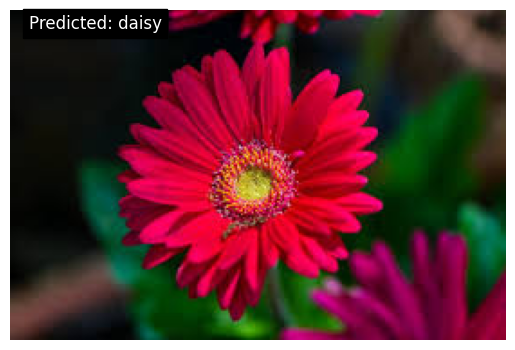

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Diaplay the image with the predicted class name 
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='black')